# Self-Similarity Priors: Neural Collages as Differentiable Fractal Representations

Michael Poli *, Winnie Xu *, Stefano Massaroli *, Chenlin Meng, Kuno Kim, Stefano Ermon

[paper](https://arxiv.org/abs/2204.07673#:~:text=Self%2DSimilarity%20Priors%3A%20Neural%20Collages%20as%20Differentiable%20Fractal%20Representations,-Michael%20Poli%2C%20Winnie&text=Many%20patterns%20in%20nature%20exhibit,described%20via%20self%2Dreferential%20transformations.) | [code](https://github.com/ermongroup/self-similarity-prior) | [demo](https://huggingface.co/spaces/Zymrael/Neural-Collage-Fractalization)

# Neural Collage Operators
Neural Collage Operators produce a fractal code: a set of parameters to a contraction map (Lipschitz constant < 1) with its attractor (fixed-point) corresponding to a desired data point. We refer to this contraction operator as a Collage Operator. Each fractal code *uniquely* identifies a data point.

## Applications of Fractal Codes

1. Compression: train your `Neural Collage Operator` on a dataset; at test time, produce the fractal code (forward encoding problem), and serialize it. To obtain the original data point, decode the collage parameters to the fixed-point.
2. Learning: as an intermediate representation.
3. Generation: as latent variables in a deep generative models.
4. Art: to "fractalize" data.

# Setup

In [3]:
!pip install functorch
!pip install einops
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as ttf
import functorch
import numpy as np
from einops import rearrange, repeat
from timm.models.convmixer import ConvMixer

import sys
import matplotlib.pyplot as plt
import torchvision.transforms.functional as ttf
from PIL import Image

%load_ext autoreload 
%autoreload 2

## Patch Utilities

In [12]:
def img_to_patches(im, patch_h, patch_w):
    "B, C, H, W -> B, C, D, h_patch, w_patch"
    bs, c, h, w = im.shape
    im = im.unfold(-1, patch_h, patch_w).unfold(2, patch_h, patch_w)
    im = im.permute(0, 1, 2, 3, 5, 4)
    im = im.contiguous().view(bs, c, -1, patch_h, patch_w)
    return im

def patches_to_img(patches, num_patch_h, num_patch_w):
    "B, C, D, h_patch, w_patch -> B, C, H, W"
    bs, c, d, h, w = patches.shape
    patches = patches.view(bs, c, num_patch_h, num_patch_w, h, w)
    # fold patches
    patches = torch.cat([patches[..., k, :, :] for k in range(num_patch_w)], dim=-1)
    x = torch.cat([patches[..., k, :, :] for k in range(num_patch_h)], dim=-2)    
    return x

def vmapped_rotate(x, angle):
    "B, C, D, H, W -> B, C, D, H, W"
    rotate_ = functorch.vmap(ttf.rotate, in_dims=2, out_dims=2)
    return rotate_(x, angle=angle)

## 2D Collage Operator 

In [13]:
class CollageOperator2d(nn.Module):

    def __init__(self, res, rh, rw, dh=None, dw=None, use_augmentations=False):
        """Collage Operator for two-dimensional data. Given a fractal code, it outputs the corresponding fixed-point.
        Args:
            res (int): Spatial resolutions of input (and output) data.
            rh (int): Height of range (target) square patches.
            rw (int): Width of range (target) square patches.
            dh (int, optional): Height of range domain (source) patches. Defaults to `res`.
            dw (int, optional): Width of range domain (source) patches. Defaults to `res`.
            use_augmentations (bool, optional): Use augmentations of domain square patches at each decoding iteration. Defaults to `False`.
        """
        super().__init__()
        self.dh, self.dw = dh, dw
        if self.dh is None: self.dh = res
        if self.dw is None: self.dw = res

        # 5 refers to the 5 copies of domain patches generated with the current choice of augmentations:
        # 3 rotations (90, 180, 270), horizontal flips and vertical flips.
        self.n_aug_transforms = 5 if use_augmentations else 1

        # precompute useful quantities related to the partitioning scheme into patches, given
        # the desired `dh`, `dw`, `rh`, `rw`. 
        partition_info = self.collage_partition_info(res, self.dh, self.dw, rh, rw)
        self.n_dh, self.n_dw, self.n_rh, self.n_rw, self.h_factors, self.w_factors, self.n_domains, self.n_ranges = partition_info
        
        # At each step of the collage, all (source) domain patches are pooled down to the size of range (target) patches.
        # Notices how the pooling factors do not change if one decodes at higher resolutions, since both domain and range 
        # patch sizes are multiplied by the same integer.
        self.pool = nn.AvgPool3d(kernel_size=(1, self.h_factors, self.w_factors), stride=(1, self.h_factors, self.w_factors))


    def decode_step(self, z, weight, bias, superres_factor):
        """Single Collage Operator step. Performs the steps described in:
        https://arxiv.org/pdf/2204.07673.pdf (Def. 3.1, Figure 2).
        """

        # Given the current iterate `z`, we split it into `n_domains` domain patches.
        domains = img_to_patches(z, patch_h=self.dh * superres_factor, patch_w=self.dw * superres_factor)

        # Pool domains (pre augmentation) for compatibility with range patches.
        pooled_domains = self.pool(domains) 

        # If needed, produce additional candidate domain patches as augmentations of existing domains.
        if self.n_aug_transforms > 1:
            pooled_domains = self.generate_candidates(pooled_domains)

        pooled_domains = repeat(pooled_domains, 'b c d h w -> b c d r h w', r=self.n_ranges)

        # Apply the affine maps to domain patches
        range_domains = torch.einsum('bcdrhw, bcdr -> bcrhw', pooled_domains, weight)
        range_domains = range_domains + bias[:, :, :, None, None]

        # Reconstruct data by "composing" the output patches back together (collage!).
        z = patches_to_img(range_domains, self.n_rh, self.n_rw)
        return z

    def generate_candidates(self, domains):
        rotations = [vmapped_rotate(domains, angle=angle) for angle in (90, 180, 270)]
        hflips = ttf.hflip(domains)
        vflips = ttf.vflip(domains)
        domains = torch.cat([domains, *rotations, hflips, vflips], dim=2)
        return domains

    def forward(self, x, co_w, co_bias, decode_steps=20, superres_factor=1):
        B, C, H, W = x.shape
        # It does not matter which initial condition is chosen, so long as the dimensions match.
        # The fixed-point of a Collage Operator is uniquely determined* by the fractal code
        # *: and auxiliary learned patches, if any.
        z = torch.randn(B, C, H * superres_factor, W * superres_factor).to(x.device)
        for _ in range(decode_steps):
            z = self.decode_step(z, co_w, co_bias, superres_factor)
        return z

    def collage_partition_info(self, input_res, dh, dw, rh, rw):
        """
        Computes auxiliary information for the collage (number of source and target domains, and relative size factors)
        """
        height = width = input_res
        n_dh, n_dw = height // dh, width // dw
        n_domains = n_dh * n_dw

        # Adjust number of domain patches to include augmentations
        n_domains = n_domains + n_domains * self.n_aug_transforms # (3 rotations, hflip, vlip)

        h_factors, w_factors = dh // rh, dw // rw
        n_rh, n_rw = input_res // rh, input_res // rw    
        n_ranges = n_rh * n_rw
        return n_dh, n_dw, n_rh, n_rw, h_factors, w_factors, n_domains, n_ranges

## 2D Neural Collage Operator

In [14]:
class NeuralCollageOperator2d(nn.Module):
    def __init__(self, out_res, out_channels, rh, rw, dh=None, dw=None, net=None, use_augmentations=False):
        super().__init__()
        self.co = CollageOperator2d(out_res, rh, rw, dh, dw, use_augmentations)
        # In a Collage Operator, the affine map requires a single scalar weight 
        # for each pair of domain and range patches, and a single scalar bias for each range.
        # `net` learns to output these weights based on the objective.
        self.co_w_dim = self.co.n_domains * self.co.n_ranges * out_channels
        self.co_bias_dim = self.co.n_ranges * out_channels
        tot_out_dim = self.co_w_dim + self.co_bias_dim

        # Does not need to be a ConvMixer: for deep generative Neural Collages `net` can be e.g, a VDVAE.
        if net is None:
            net = ConvMixer(dim=32, depth=8, kernel_size=9, patch_size=7, num_classes=tot_out_dim)
        self.net = net

        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, x, decode_steps=10, superres_factor=1, return_co_code=False):
        B, C, H, W = x.shape
        co_code = self.net(x) # B, C, co_w_dim + co_mix_dim + co_bias_dim
        co_w, co_bias = torch.split(co_code, [self.co_w_dim, self.co_bias_dim], dim=-1)

        co_w = co_w.view(B, C, self.co.n_domains, self.co.n_ranges)
        co_bias = co_bias.view(B, C, self.co.n_ranges)
        co_bias = self.tanh(co_bias)
        
        z = self.co(x, co_w, co_bias, decode_steps=decode_steps, superres_factor=superres_factor)
        
        if return_co_code: return z, co_w, co_bias
        else: return z

# Learning Collage Representations of Image Data

## Load example image

In [8]:
import tensorflow as tf
import os

image_path = tf.keras.utils.get_file(
      'einstein375.png',
      'https://firebasestorage.googleapis.com/v0/b/sde-bnn.appspot.com/o/neural-collage%2Feinstein375.png?alt=media&token=e2160ac0-c88a-4f62-9ccd-86de5476d82e',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'einstein375.png')

In [10]:
im = Image.open(image_path)
im = np.asarray(im)
im = torch.from_numpy(im).permute(2, 0, 1).unsqueeze(0)[:, :3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  This is separate from the ipykernel package so we can avoid doing imports until


## Train a Neural Collage

In [19]:
out_res=375 #@param
out_channels=3 #@param
range_patch_height=5 #@param
range_patch_width=5 #@param
domain_patch_height=375 #@param
domain_patch_width=375 #@param

n_iterations = 200 #@param
n_decode_steps = 10 #@param
return_co_code = False #@param

In [17]:
co = NeuralCollageOperator2d(out_res=out_res, out_channels=out_channels, rh=range_patch_height, rw=range_patch_width, dh=domain_patch_height, dw=domain_patch_width, use_augmentations=False)

In [20]:
# Train the collage operator encoder
opt = torch.optim.Adam(co.parameters(), lr=1e-2)
objective = nn.MSELoss()
norm_im = im.float() / 255

for k in range(n_iterations):
    recon = co(norm_im, decode_steps=n_decode_steps, return_co_code=return_co_code)
    loss = objective(recon, norm_im)
    print(f'Reconstruction MSE: {loss}', end='\r')
    loss.backward()
    opt.step()
    opt.zero_grad()

## Visualize the Fixed Point

1) The Neural Collage Operator encoder produces the fractal code for `norm_im`

2) The reconstruction is produced as the fixed point of the Collage Operator with the given fractal code

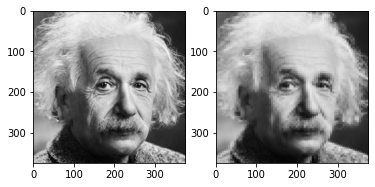

In [21]:
recon = co(norm_im, decode_steps=10)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(norm_im[0].permute(1,2,0), cmap='bone')
axs[1].imshow(recon[0].permute(1,2,0).detach(), cmap='bone')

## View Fractal Code

Set `return_co_code=True` to obtain the number of bytes required to serialize the fractal code. 

From an image compression standpoint, we may employ additional methods to optimize the code length of fractal codes for Neural Collage Operators.

One compression strategy (further details in our paper) involves L2-regularization on fractal weights to shrink their range, which enables efficient bit packing. 

As a rule of thumb, the simplest compression codec based on Neural Collage Operators is expected to have higher compression ratios (e.g, PSNR / bits per dim) than the comparable fractal compression scheme and also neural implicit compressors (COIN), with slightly less efficiency at med-level and higher bits per dim compared to block DCT-II. 

Neural Collages are much faster than fractal compression and COIN in the forward encoding phase, but there is still much room for improvement!

In [22]:
_, fractal_weight, fractal_bias = co(norm_im, decode_steps=10, return_co_code=True)
size_fractal_code = ( torch.numel(fractal_weight) + torch.numel(fractal_bias) )
raw_img_size = torch.numel(im)
print(f'Ratio: size fractal code / size of raw image is {size_fractal_code / raw_img_size}')

Ratio: size fractal code / size of raw image is 0.12


## Fractal Decoding

An interesting property of Collage Operators (and hence Neural Collage Operators) is the ability to decode, given a fractal code, at any resolution.

For the sake of practicality, our implementation is restricted to resolutions that are multiples of the original image resolution.
Pass this "super resolution factor" as `superres_factor`.

### Decode at 4 times the original 375 x 375 resolution... 


In [23]:
superres_factor = 4 #@param

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original image size: torch.Size([1, 3, 375, 375]) | super-resolved image: torch.Size([1, 3, 1500, 1500])


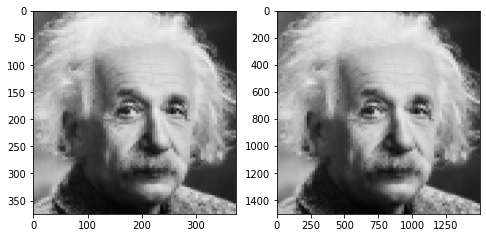

In [28]:
recon_sup = co(norm_im, decode_steps=10, superres_factor=superres_factor)
print(f'original image size: {norm_im.shape} | super-resolved image: {recon_sup.shape}')

fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(recon[0].permute(1,2,0).detach(), cmap='bone')
axs[1].imshow(recon_sup[0].permute(1,2,0).detach(), cmap='bone')

### zooming in... 👀 Einstein made of Einsteins?

This example shows the "fractalness" of the code representations produced by a Neural Collage Operator.

In other words, we see similar data appearing at different scales of resolution!
 
The additional visual details introduced by decoding at higher resolutions are based on the image itself. If decoding at even larger resolutions, it is possible to see multiple levels of "fractalness" when decoding at larger resolutions (see Figure 1 and Figure 13 in the paper). 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


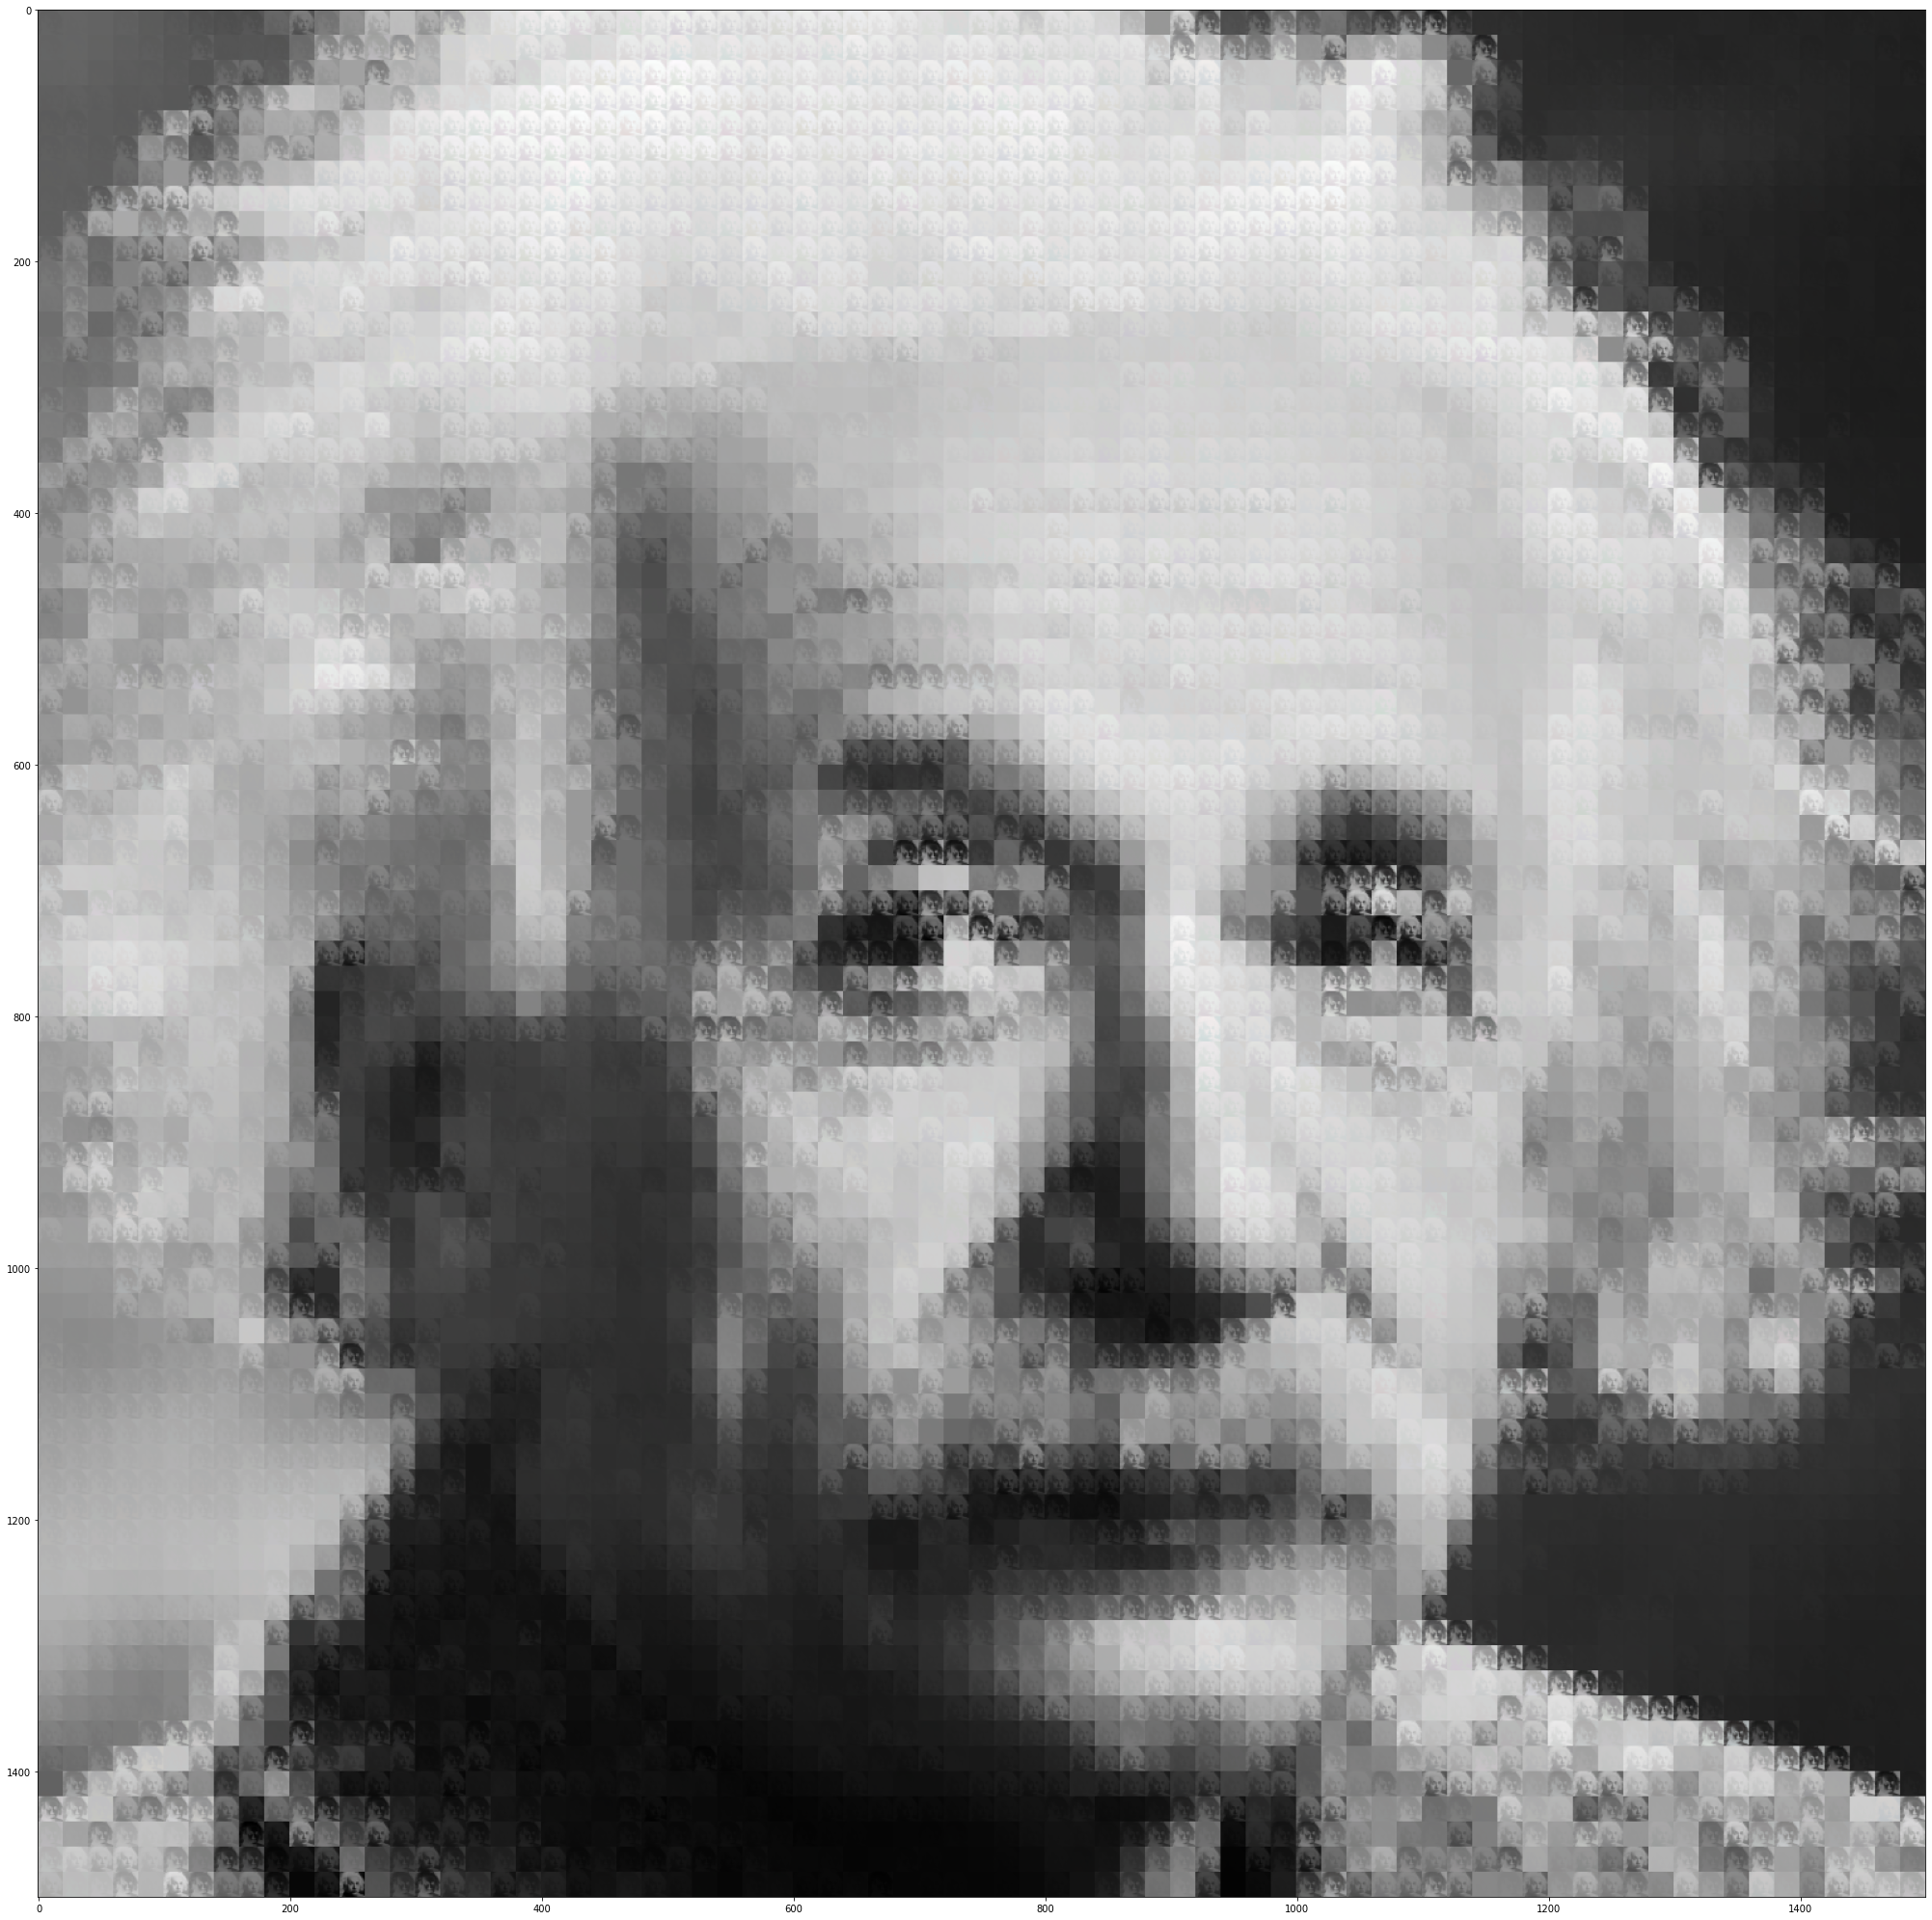

In [27]:
plt.figure(figsize=(36,36))
plt.imshow(recon_sup[0].permute(1,2,0).detach(), cmap='bone')

## Adding Augmentations

Set `use_augmentations=True` while training the Collage Operator encodings to obtain a similar effect but with even more interesting details in the decoded image.

In [29]:
use_augmentations = True #@param

In [30]:
co = NeuralCollageOperator2d(out_res=out_res, out_channels=out_channels, rh=range_patch_height, rw=range_patch_width, dh=domain_patch_height, dw=domain_patch_width, use_augmentations=use_augmentations)

opt = torch.optim.Adam(co.parameters(), lr=1e-2)
objective = nn.MSELoss()
norm_im = im.float() / 255

for k in range(n_iterations):
    recon = co(norm_im, decode_steps=n_decode_steps, return_co_code=False)
    loss = objective(recon, norm_im)
    print(f'Reconstruction MSE: {loss}', end='\r')
    loss.backward()
    opt.step()
    opt.zero_grad()

### zooming in to the details...

Notice the added clarity of additional details / textures in the example to the right.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original image size: torch.Size([1, 3, 375, 375]) | super-resolved image: torch.Size([1, 3, 1500, 1500])


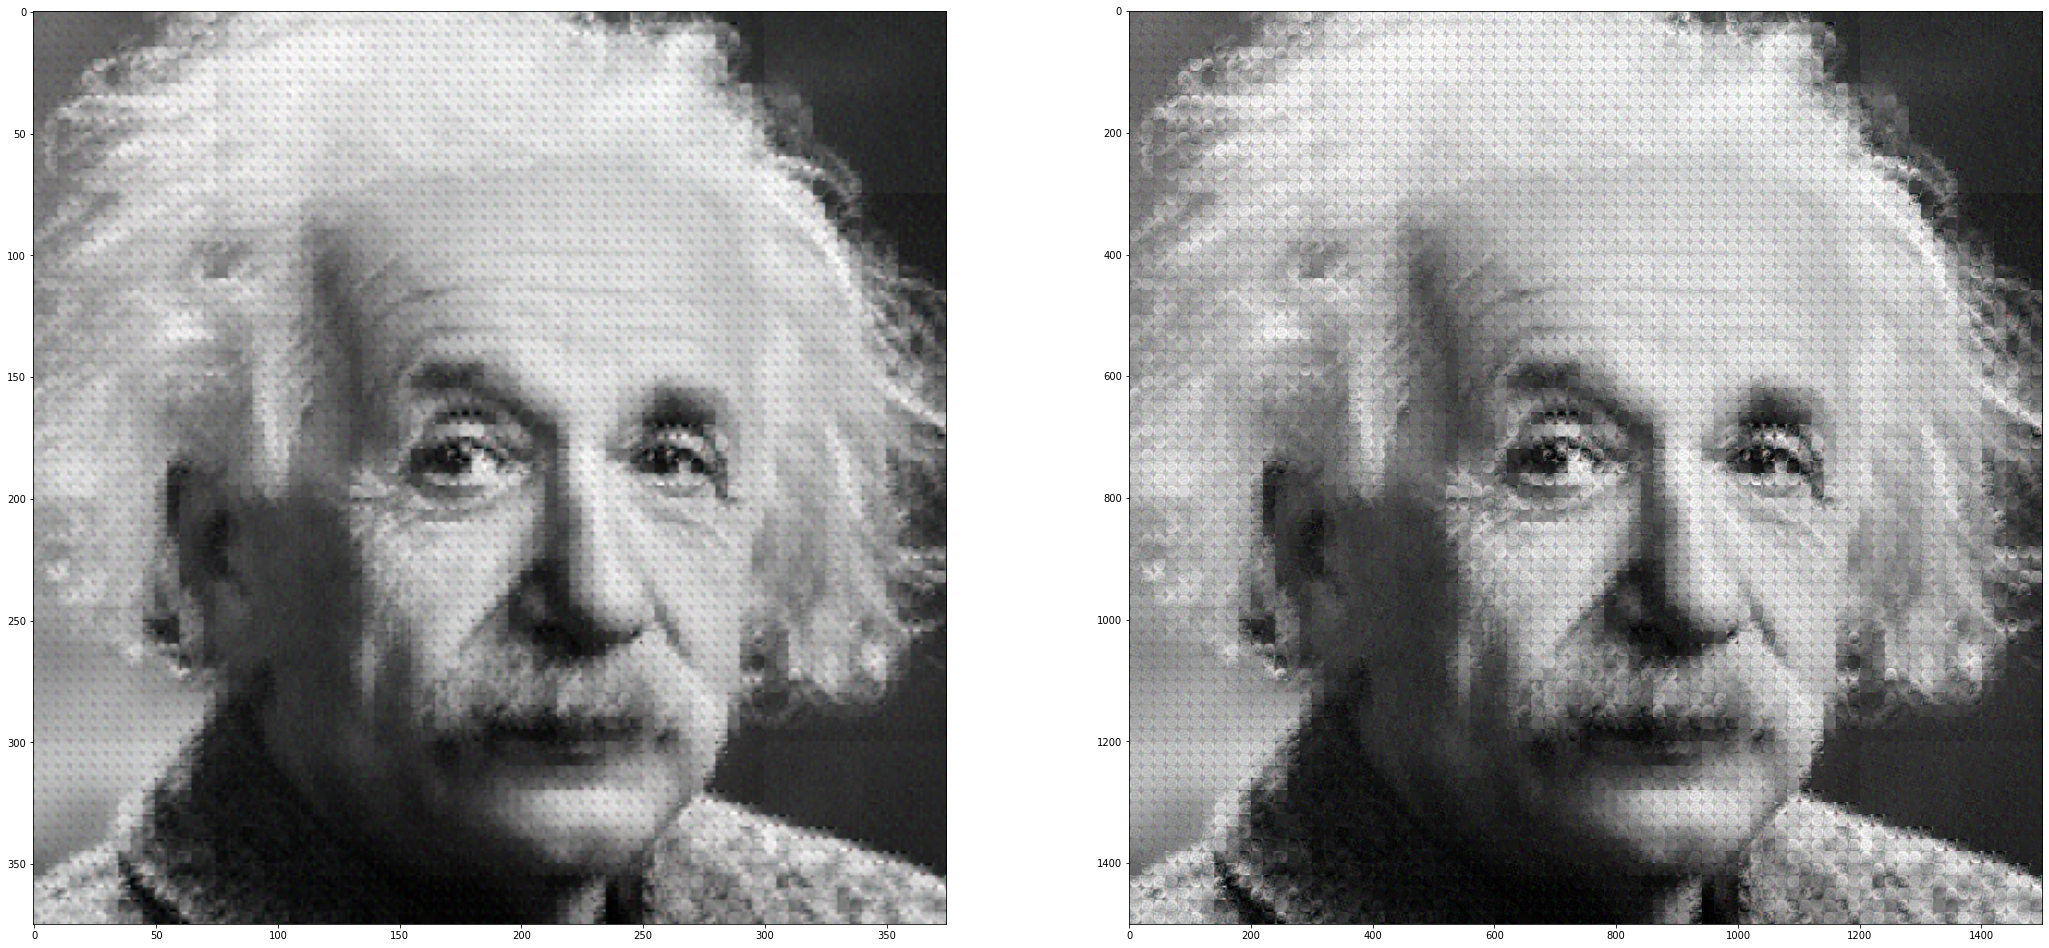

In [32]:
recon = co(norm_im, decode_steps=10)
recon_sup = co(norm_im, decode_steps=10, superres_factor=4)
print(f'original image size: {norm_im.shape} | super-resolved image: {recon_sup.shape}')

fig, axs = plt.subplots(1, 2, figsize=(36, 36))
axs[0].imshow(recon[0].permute(1,2,0).detach(), cmap='bone')
axs[1].imshow(recon_sup[0].permute(1,2,0).detach(), cmap='bone')